In [1]:
!pip install transformers
!python -m pip install -U xgboost

     |████████████████████████████████| 1.8MB 6.0MB/s 
     |████████████████████████████████| 2.9MB 43.1MB/s 
     |████████████████████████████████| 890kB 40.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=dc67afcc04aac23947bc801459bc92c56ae2b8d7a0969a020783685b3d41eda0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 157.5MB 83kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
# general libraries
#imports
from os.path import join as pathjoin;
from os import listdir;
import os;
import re;
import json;
import matplotlib.pyplot as plt;
import pandas as pd;
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import numpy
import sklearn.pipeline
from gensim.models import KeyedVectors
from sklearn.model_selection import GridSearchCV
import math,glob

from mlxtend.regressor import StackingRegressor
from sklearn import linear_model
from sklearn.ensemble.forest import RandomForestRegressor as RFR
from sklearn.ensemble.forest import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn import neural_network
import xgboost as xgb


from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

import random

random.seed(42)
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# bert related libraries
import torch
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel, AutoModelWithLMHead

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Carregamentos

In [5]:
#base_path = '/content/gdrive/My Drive/Mestrado/EnglishV4/'
#dev_data_path = pathjoin(base_path,'DBDC4_dev_20190312/DBDC4_dev_20190312/en')
#eval_data_path = pathjoin(base_path,'DBDC4_eval_20200314/DBDC4_eval_20200314/en')

base_path = '/content/gdrive/My Drive/Mestrado/Conjuntos/DBDC4'
#base_path = 'C:/Users/Leonardo de Andrade/Dropbox/python/dbdc3/'
dev_data_path = pathjoin(base_path,'DBDC4_dev_20190312')
eval_data_path = pathjoin(base_path,'DBDC4_eval_20200314')

dbdc3_path = '/content/gdrive/My Drive/Mestrado/English/crf_baseline/train'

In [6]:
def loadConversations(paths):
    conversations = []
    for path in paths:
      for f in glob.glob(path + '/*.log.json'):
        json_obj = json.load(open(pathjoin(path,f), encoding='utf-8'))
        json_obj['file_name'] = f
        conversations.append(json_obj)
    return conversations

In [7]:
def SetMajorityVoteAndDistribution(conversations, threshold):
    for c in conversations:
        for t in c['turns']:
            count={}
            count['O']=0
            count['T']=0
            count['X']=0
            hasAnnotations = False
            for a in t['annotations']:
                hasAnnotations = True
                count[a['breakdown']] +=1
            del t['annotations']
            if hasAnnotations:
                #distribution
                t['O'] = count['O']*1.0 / (count['O'] + count['T'] + count['X'])
                t['T'] = count['T']*1.0 / (count['O'] + count['T'] + count['X'])
                t['X'] = count['X']*1.0 / (count['O'] + count['T'] + count['X']) 
                #majorityVoting
                t['class'] = 'O'
                t['class'] = 'X' if t['X']>=t['T'] and t['X']>=t['O'] and t['X']>=threshold else t['class']
                t['class'] = 'T' if t['T']>=t['O'] and t['T']>=t['X'] and t['T']>=threshold else t['class']
                t['class'] = 'O' if t['O']>=t['T'] and t['O']>=t['X'] and t['O']>=threshold else t['class']
                
    return conversations

In [8]:
def resultArray(pipeline, test, testPred):
    #test.sort_values(['file_name', 'user-index'], ascending=[True, True])
    result ={}
    data = {}
    data['turns'] = []
    size = test.shape[0]
    predictedValues = pipeline.predict(testPred)
    predictedProbas = pipeline.predict_proba(testPred)
    for i in range(size):
        data['dialogue-id'] = test.iloc[i]['dialogue-id']
        result[data['dialogue-id']] = data
        predictedValue = scoreToLabel(predictedValues[i])
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test.iloc[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = predictedProba[1]
        label['prob-X'] = predictedProba[2] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test.iloc[i]['file_name'] != test.iloc[i+1]['file_name']:
            data = {}
            data['turns'] = []
    return result

In [9]:
def ConversationClassCount(conversations):
    count={}
    count['O']=0
    count['T']=0
    count['X']=0
    for c in conversations:
        for t in c['turns']:
            if 'class' in t:
                count[t['class']] += 1
    return count

In [10]:
def scoreToLabel(score):
    score_float = float(score)
    if score_float<0.4:
        return 'O'
    elif score_float <0.8:
        return 'T'
    else:
        return 'X'

**Métodos de avaliação**

In [11]:
def calc_distribution(annotations) :
    count_O = 0
    count_T = 0
    count_X = 0

    for annotation in annotations:
        if annotation['breakdown'] == 'O':
            count_O += 1
        elif annotation['breakdown'] == 'T':
            count_T += 1
        elif annotation['breakdown'] == 'X':
            count_X += 1

    prob_O = count_O*1.0 / (count_O + count_T + count_X)
    prob_T = count_T*1.0 / (count_O + count_T + count_X)
    prob_X = count_X*1.0 / (count_O + count_T + count_X)

    return [prob_O, prob_T, prob_X]

In [12]:
def majority_label(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T and prob_O >= prob_X and prob_O >= threshold:
        return "O"
    elif prob_T >= prob_O and prob_T >= prob_X and prob_T >= threshold:
        return "T"
    elif prob_X >= prob_T and prob_X >= prob_O and prob_X >= threshold:
        return "X"
    else:
        return "O"

In [13]:
def majority_label_lenient(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T + prob_X and prob_O >= threshold:
        return "O_l"
    elif prob_T + prob_X >= prob_O and prob_T + prob_X >= threshold:
        return "X_l"
    else:
        return "O_l"

In [14]:
def kld(p, q):
    k = 0.0
    for i in range(len(p)):
        if p[i] > 0:
            k += p[i] * (math.log(p[i]/q[i],2))
    return k

In [15]:
def jsd(p, q):
    m = []
    for i in range(len(p)):
        m.append((p[i]+q[i])/2.0)

    return (kld(p,m) + kld(q,m)) / 2.0

In [16]:
def mse(p, q):
    total = 0.0

    for i in range(len(p)):
        total += pow(p[i] - q[i],2)

    return total / len(p)

In [17]:
def evaluationAsDict(data_path,eval_data,threshold):

    file_num = 0
    label_num = 0

    correct_num = 0
    incorrect_num = 0

    predO_ansO = 0
    predO_ansT = 0
    predO_ansX = 0
    predT_ansO = 0
    predT_ansT = 0
    predT_ansX = 0
    predX_ansO = 0
    predX_ansT = 0
    predX_ansX = 0

    predO_ansO_l = 0
    predO_ansX_l = 0
    predT_ansO_l = 0
    predT_ansX_l = 0
    predX_ansO_l = 0
    predX_ansX_l = 0

    jsd_O_T_X_sum = 0.0
    jsd_O_TX_sum = 0.0
    jsd_OT_X_sum = 0.0
    mse_O_T_X_sum = 0.0
    mse_O_TX_sum = 0.0
    mse_OT_X_sum = 0.0

    pred_dist_list = []
    ans_dist_list = []

    #parser = argparse.ArgumentParser()
    #parser.add_argument('-p', dest='datapath', action='store', metavar='TESTDIR', required=True,
                        #help='テスト用の対話データが入ったディレクトリ')
    #parser.add_argument('-o', dest='evalpath', action='store', metavar='EVALDIR', required=True,
                        #help='評価用データが入ったディレクトリ')
    #parser.add_argument('-t', dest='threshold', action='store', metavar='THRESHOLD', required=False,
                        #help='正解ラベルを決定するためのしきい値')

    #args = parser.parse_args()

    #data_path = args.datapath
    #eval_path = args.evalpath

    #threshold = 0.0
    #if args.threshold != None:
    #    threshold = float(args.threshold)

    #if not data_path.endswith('/') or not data_path.endswith('\\'):
        #data_path += '/'
    #if not eval_path.endswith('/') or not eval_path.endswith('\\'):
        #eval_path += '/'

    data_files = glob.glob(data_path + '/*log.json')
    
    for f in data_files:
    #for data_json in data_files:
        file_num += 1

        data_fp = open(f, "r")
        data_json = json.load(data_fp)
        data_fp.close()

        dlg_id = data_json["dialogue-id"]
        #eval_fp = open(eval_path + dlg_id + ".labels.json", "r")
        #eval_json = json.load(eval_fp)
        #eval_fp.close()
        
        eval_json = eval_data[dlg_id]
        #print(dlg_id)
        eval_index = 0
        for turn in data_json['turns']:
            if turn['speaker'] == "U" or turn['annotations']==[]:  # modified Sep 17 2017
                continue

            label_num += 1

            ans_prob_dist = calc_distribution(turn['annotations'])
            ans_dist_list.append(ans_prob_dist)
            ans_label = majority_label(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            ans_label_l = majority_label_lenient(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            #print(f)
            target_label = eval_json['turns'][eval_index]['labels'][0]
            
            #print(str(ans_label)+','+str(target_label['breakdown'])+','+ str(turn['turn-index'])+','+ str(eval_json['turns'][eval_index]['turn-index']))

            pred_prob_dist = [float(target_label['prob-O']), float(target_label['prob-T']), float(target_label['prob-X'])]
            pred_dist_list.append(pred_prob_dist)

            jsd_O_T_X_sum += jsd(ans_prob_dist,pred_prob_dist)
            jsd_O_TX_sum += jsd([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            jsd_OT_X_sum += jsd([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            mse_O_T_X_sum += mse(ans_prob_dist,pred_prob_dist)
            mse_O_TX_sum += mse([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            mse_OT_X_sum += mse([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            pred_label = target_label['breakdown']
            eval_index += 1

            if pred_label == ans_label:
                correct_num += 1
            else:
                incorrect_num += 1

            if pred_label == "O":
                if ans_label == "O":
                    predO_ansO += 1
                elif ans_label == "T":
                    predO_ansT += 1
                elif ans_label == "X":
                    predO_ansX += 1
            elif pred_label == "T":
                if ans_label == "O":
                    predT_ansO += 1
                elif ans_label == "T":
                    predT_ansT += 1
                elif ans_label == "X":
                    predT_ansX += 1
            elif pred_label == "X":
                if ans_label == "O":
                    predX_ansO += 1
                elif ans_label == "T":
                    predX_ansT += 1
                elif ans_label == "X":
                    predX_ansX += 1

            #lenient
            if pred_label == "O":
                if ans_label_l == "O_l":
                    predO_ansO_l += 1
                elif ans_label_l == "X_l":
                    predO_ansX_l += 1
            elif pred_label == "T":
                if ans_label_l == "O_l":
                    predT_ansO_l += 1
                elif ans_label_l == "X_l":
                    predT_ansX_l += 1
            elif pred_label == "X":
                if ans_label_l == "O_l":
                    predX_ansO_l += 1
                elif ans_label_l == "X_l":
                    predX_ansX_l += 1


#     print correct_num
#     print incorrect_num
#
#     print predO_ansO
#     print predO_ansT
#     print predO_ansX
#     print predT_ansO
#     print predT_ansT
#     print predT_ansX
#     print predX_ansO
#     print predX_ansT
#     print predX_ansX


    #print str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l + predO_ansX_l + predO_ansO_l)
    
    print("######### Data Stats #########")
    print("File Num : \t\t" + str(file_num))
    print("System Utterance Num : \t" + str(label_num))
    print("O Label Num : \t\t" + str(predO_ansO + predT_ansO + predX_ansO))
    print("T Label Num : \t\t" + str(predO_ansT + predT_ansT + predX_ansT))
    print("X Label Num : \t\t" + str(predO_ansX + predT_ansX + predX_ansX))
    print("")

    print("######### Results #########")
    print("Accuracy : \t\t%4f" % ((correct_num*1.0) / (correct_num + incorrect_num)) + " (" + str(correct_num) + "/" + str(correct_num + incorrect_num) + ")\n")

    precision_s = 0.0
    recall_s = 0.0
    fmeasure_s = 0.0

    if predX_ansX > 0:
        if (predX_ansO + predX_ansT + predX_ansX) > 0:
            precision_s = predX_ansX*1.0 / (predX_ansO + predX_ansT + predX_ansX)
        if (predO_ansX + predT_ansX + predX_ansX) > 0:
            recall_s = predX_ansX*1.0 / (predO_ansX + predT_ansX + predX_ansX)

    if precision_s > 0 and recall_s > 0:
        fmeasure_s = (2*precision_s*recall_s)/(precision_s + recall_s)

    print("Precision (X) : \t%4f" % (precision_s) + " (" + str(predX_ansX) + "/" + str(predX_ansO + predX_ansT + predX_ansX) + ")")
    print("Recall    (X) : \t%4f" % (recall_s) + " (" + str(predX_ansX) + "/" + str(predO_ansX + predT_ansX + predX_ansX) + ")")
    print("F-measure (X) : \t%4f" % (fmeasure_s) + "\n")


    precision_l = 0.0
    recall_l = 0.0
    fmeasure_l = 0.0
    if (predT_ansX_l + predX_ansX_l) > 0 and (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) > 0:
        precision_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l)
    if (predT_ansX_l + predX_ansX_l) > 0 and (predO_ansX_l + predT_ansX_l + predX_ansX_l) > 0:
        recall_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predO_ansX_l + predT_ansX_l + predX_ansX_l)
    if precision_l > 0 and recall_l > 0:
        fmeasure_l = (2*precision_l*recall_l)/(precision_l + recall_l)



    print("Precision (T+X) : \t%4f" % (precision_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) + ")")
    print("Recall    (T+X) : \t%4f" % (recall_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predO_ansX_l + predT_ansX_l + predX_ansX_l) + ")")
    print("F-measure (T+X) : \t%4f" % (fmeasure_l) + "\n")

    print("JS divergence (O,T,X) : \t%4f" % (jsd_O_T_X_sum / (correct_num + incorrect_num)))
    print("JS divergence (O,T+X) : \t%4f" % (jsd_O_TX_sum / (correct_num + incorrect_num)))
    print("JS divergence (O+T,X) : \t%4f" % (jsd_OT_X_sum / (correct_num + incorrect_num)) + "\n")

    print("Mean squared error (O,T,X) : \t%4f" % (mse_O_T_X_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O,T+X) : \t%4f" % (mse_O_TX_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O+T,X) : \t%4f" % (mse_OT_X_sum / (correct_num + incorrect_num)))
    print("###########################")
    
    result_ans = {
        "fileNumber":file_num,
        "systemUtterance":label_num,
        "ansO": predO_ansO + predT_ansO + predX_ansO,
        "ansT": predO_ansT + predT_ansT + predX_ansT,
        "ansX": predO_ansX + predT_ansX + predX_ansX,
        "accuracy": ((correct_num*1.0) / (correct_num + incorrect_num)),
        "precisionX": precision_s,
        "predX_ansX":predX_ansX,
        "total_predX": predX_ansO + predX_ansT + predX_ansX,
        "total_ansX": predO_ansX + predT_ansX + predX_ansX,
        "recallX": recall_s,
        "f1X": fmeasure_s,
        
        "precisionTX":precision_l,
        "recallTX": recall_l,
        "f1TX": fmeasure_l,
        
        "totalTXAnsX": predT_ansX_l + predX_ansX_l,
        "totalPredX+PredT" : predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l,
        "totalAnsX" : predO_ansX_l + predT_ansX_l + predX_ansX_l,
        
        "js-O-T-X" : (jsd_O_T_X_sum / (correct_num + incorrect_num)),
        "js-O-T+X" : (jsd_O_TX_sum / (correct_num + incorrect_num)),
        "js-O+T-X" : (jsd_OT_X_sum / (correct_num + incorrect_num)),

        "mse-O-T-X" :  (mse_O_T_X_sum / (correct_num + incorrect_num)),
        "mse-O-T+X" :  (mse_O_TX_sum / (correct_num + incorrect_num)),
        "mse-O+T-X" :  (mse_OT_X_sum / (correct_num + incorrect_num))        
        
    }
    
    return result_ans

In [18]:
def PrepareDataSetWithTail(conversations):
    items = conversations.copy()
    result = []
    for c in items:
        #if c['turns'][0]['speaker']=='S':
            #del c['turns'][0]
        turns_len = len(c['turns'])
        userTurnTail = ''
        systemTurnTail = ''
        for i in range(0,turns_len):
            if i == 0 and c['turns'][i]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                line['user-utterance'] = ''
                line['system-utterance'] = c['turns'][i]['utterance']                
                #line['user-utterance-tail'] = ''
                #line['system-utterance-tail'] = c['turns'][i]['utterance']                
                line['system-index'] = c['turns'][i]['turn-index']                
                line['O'] = 1
                line['T'] = 0
                line['X'] = 0
                line['class']=0
                result.append(line)
                
            if i+1<turns_len and c['turns'][i]['speaker'] == 'U' and c['turns'][i+1]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                
                #userTurnTail = userTurnTail + ' ' + c['turns'][i]['utterance']
                line['user-utterance'] = c['turns'][i]['utterance']
                
                #systemTurnTail = systemTurnTail + ' ' + c['turns'][i+1]['utterance']
                line['system-utterance'] = c['turns'][i+1]['utterance']
                
                #line['user-utterance-tail'] = GetLastNTurns(c['turns'],i,windowSize)
                #line['system-utterance-tail'] = GetLastNTurns(c['turns'],i+1,windowSize)
                
                line['system-index'] = c['turns'][i+1]['turn-index']                
                line['O'] = c['turns'][i+1]['O']
                line['T'] = c['turns'][i+1]['T']
                line['X'] = c['turns'][i+1]['X']
                if c['turns'][i+1]['class'] == 'O':
                    line['class']=0
                elif c['turns'][i+1]['class'] == 'T':
                    line['class'] = 0.5
                elif c['turns'][i+1]['class'] == 'X':
                    line['class'] = 1
                else:
                    line['class'] = None
                #line['class'] = c['turns'][i+1]['class']
                result.append(line)
    return result

## Carregando o voto majoritário

In [19]:
json_dev_dev = SetMajorityVoteAndDistribution(loadConversations([dev_data_path,dbdc3_path]),0)
json_dev_test = SetMajorityVoteAndDistribution(loadConversations([eval_data_path]),0)

## Carregando BERT

In [20]:
def addBert(data, columnName, newColumn):
  english = 'bert-base-cased'
  portuguese = "neuralmind/bert-large-portuguese-cased",
  multilingual = "bert-base-multilingual-cased"

  bert_config ={
      'en' :'bert-base-cased',
      'pt': "neuralmind/bert-large-portuguese-cased",
      'fr':'dbmdz/bert-base-french-europeana-cased',
      'sp': "dccuchile/bert-base-spanish-wwm-cased",
      'it': "dbmdz/bert-base-italian-cased",
      'pl': "dkleczek/bert-base-polish-cased-v1",
      'all':{
          'model': "bert-base-multilingual-cased"
      }
  }
  data[columnName].fillna(' ',inplace=True)
  tokenizer = AutoTokenizer.from_pretrained(english)
  tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t), data[columnName]))
  result = pd.DataFrame({'token_len':[len(t) for t in tokens]}).describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.99,1]).T
  display(result)
  max_size = result['max']+5

  tokenizer = AutoTokenizer.from_pretrained(english)
  model = AutoModel.from_pretrained(english).cuda()

  MAXLENGTH = int(max_size)
  tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:MAXLENGTH-1], data[columnName]))
  tokens_ids = list(map(tokenizer.convert_tokens_to_ids, tokens))
  tokens_ids = tf.keras.preprocessing.sequence.pad_sequences(tokens_ids, maxlen=MAXLENGTH, truncating='post', padding='post', dtype='int64')
  tensors = torch.tensor(tokens_ids)
  dataloader = DataLoader(TensorDataset(tensors), batch_size=16)
  with torch.no_grad():
      results = []
      for t in tqdm(iter(dataloader)):
          t = t[0]
          result = model(t.cuda())
          result = result[0][range(len(t)), -1, :]
          results.append(result.cpu())
      results = torch.cat(results).numpy()
  data[newColumn]= results.tolist()

In [21]:
train = pd.DataFrame(PrepareDataSetWithTail(json_dev_dev))
test = pd.DataFrame(PrepareDataSetWithTail(json_dev_test))

In [22]:
addBert(train,'user-utterance','user-bert')
addBert(train,'system-utterance','system-bert')

,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,5337.0,7.429267,4.547755,1.0,5.0,7.0,9.0,10.0,13.0,23.0,39.0,39.0


100%|██████████| 334/334 [00:08<00:00, 37.39it/s]


,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,5337.0,11.807382,8.208033,1.0,6.0,10.0,15.0,17.0,22.0,40.0,72.0,72.0


100%|██████████| 334/334 [00:14<00:00, 23.33it/s]


In [26]:
addBert(test,'user-utterance','user-bert')
addBert(test,'system-utterance','system-bert')

,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,2166.0,7.583564,5.214493,1.0,5.0,7.0,10.0,10.0,14.0,25.35,50.0,50.0


100%|██████████| 136/136 [00:04<00:00, 33.32it/s]


,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,2166.0,13.838412,8.243787,2.0,8.0,12.0,17.0,19.0,25.0,42.0,62.0,62.0


100%|██████████| 136/136 [00:04<00:00, 28.18it/s]


## Transformers

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [28]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse

class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [29]:
import numpy
from sklearn.base import BaseEstimator, TransformerMixin
class WindowItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key, conversationKey, windowSize):
        self.key = key
        self.conversationKey = conversationKey
        self.windowSize =windowSize

    def fit(self, x, y=None):
        return self
    
    def getLastXTurns(self,turns,index,startIndex,n):
        arrayToResult = numpy.array(turns[index])
        i = 1
        while n > 0 and index > startIndex:
            i = i+1
            index = index -1
            n = n-1
            arrayToResult = arrayToResult + numpy.array(turns[index])
        return arrayToResult / i

    def doExecute(self,arrayTest, conversationIds, windowSize):
        newArrayTest =[]
        lastId = conversationIds[0]
        lastStartIndex = 0
        for index in range(len(arrayTest)):
            if lastId != conversationIds[index]:
                lastId = conversationIds[index]
                lastStartIndex = index
            newArrayTest.append(self.getLastXTurns(arrayTest,index,lastStartIndex,windowSize))
        return newArrayTest
        
    def transform(self, data_dict):
        return self.doExecute(data_dict[self.key], data_dict[self.conversationKey], self.windowSize)

## Modelo

In [30]:
parameters = {'windowSize': 3, 
              'tfidf__min_df': 2, 
              'tfidf__max_df': 0.668807585701814, 
              'gbr__n_estimators': 50, 
              'gbr__learning_rate': 0.01, 
              'gbr__max_depth': 4, 
              'stop_words': 'english', 
              'ngram_range': [1, 3]}
 
tuned_parameters = {
    'windowSize': 4, 
    'tfidf__min_df': 4, 
    'tfidf__max_df': 0.7697900660077518, 
    'gbr__n_estimators': 50, 
    'gbr__learning_rate': 0.001, 
    'gbr__max_depth': 3, 
    'stop_words': None, 
    'ngram_range': [1, 2], 
    'min_samples_leaf': 0.001
    }

{'windowSize': 4, 'tfidf__min_df': 4, 'tfidf__max_df': 0.7697900660077518, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [1, 2], 'min_samples_leaf': 0.001}
######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.385500 (771/2000)

Precision (X) : 	0.269024 (350/1301)
Recall    (X) : 	0.727651 (350/481)
F-measure (X) : 	0.392817

Precision (T+X) : 	0.673328 (876/1301)
Recall    (T+X) : 	0.688679 (876/1272)
F-measure (T+X) : 	0.680917

JS divergence (O,T,X) : 	0.086276
JS divergence (O,T+X) : 	0.059626
JS divergence (O+T,X) : 	0.049234

Mean squared error (O,T,X) : 	0.046488
Mean squared error (O,T+X) : 	0.070480
Mean squared error (O+T,X) : 	0.045229
###########################


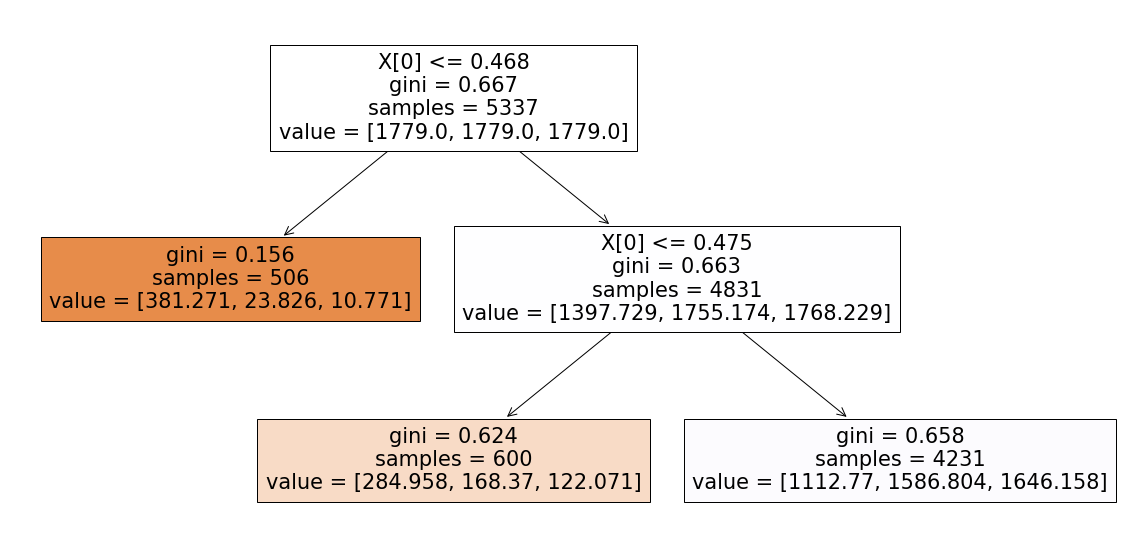

In [31]:
from tqdm import tqdm
import numpy as np

def build_pipeline(params):
    pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          stop_words=params['stop_words'],
                                          ngram_range=(params['ngram_range'][0],params['ngram_range'][1]))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          stop_words=params['stop_words'],
                                          ngram_range=(params['ngram_range'][0],params['ngram_range'][1]))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-bert',
                                                          conversationKey='dialogue-id',
                                                          windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-bert',
                                                            conversationKey='dialogue-id',
                                                            windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ]))

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', GBR(n_estimators=params['gbr__n_estimators'],
                learning_rate=params['gbr__learning_rate'],
                max_depth=params['gbr__max_depth'],
                random_state=0))])
    
    return pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree

N_ITER = 100

best_model = None
best_classifier = None
best_result = -np.inf
#tuned_parameters = None
results_iter = []

random.seed(42)
np.random.seed(42)

try:
  print(tuned_parameters)
  pipeline = build_pipeline(tuned_parameters)
  pipeline.fit(train, train['class'])
    
  trainPred = pipeline.predict(train)
  testPred = pipeline.predict(test)
    
  #tirar max_leaf_nodes
  classifier = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3, class_weight="balanced", random_state=0)
  classifier.fit(trainPred.reshape(-1,1),train['class'].astype(str).values.reshape(-1,1))
  trainPred2 = classifier.predict(trainPred.reshape(-1,1))
  testPred2 = classifier.predict(testPred.reshape(-1,1))
    
  predicted = resultArray(classifier, test, testPred.reshape(-1,1))
  output = evaluationAsDict(eval_data_path,predicted,0)

  plt.figure(figsize=(20,10)) 
  plot_tree(classifier, filled=True) 
  plt.show()

except Exception as e: 
    print(e)
    print('error')

In [ ]:
dict = {}
for p in predicted:
    for t in predicted[p]['turns']:
        dict[p + '-' + str(t['turn-index'])]= t['labels'][0]['breakdown']
json.dumps(dict)

'{"iris_DBDC4_114-0": "O", "iris_DBDC4_114-2": "O", "iris_DBDC4_114-4": "X", "iris_DBDC4_114-6": "X", "iris_DBDC4_114-8": "X", "iris_DBDC4_114-10": "X", "iris_DBDC4_114-12": "X", "iris_DBDC4_114-14": "X", "iris_DBDC4_114-16": "X", "iris_DBDC4_114-18": "X", "iris_DBDC4_114-20": "O", "Bot002_072-1": "X", "Bot002_072-3": "X", "Bot002_072-5": "O", "Bot002_072-7": "O", "Bot002_072-9": "O", "Bot002_072-11": "O", "Bot002_072-13": "O", "Bot002_072-15": "X", "Bot002_072-17": "O", "Bot002_072-19": "X", "Bot003_021-0": "O", "Bot003_021-2": "X", "Bot003_021-4": "O", "Bot003_021-6": "X", "Bot003_021-8": "O", "Bot003_021-10": "X", "Bot003_021-12": "X", "Bot003_021-14": "X", "Bot003_021-16": "X", "Bot003_021-18": "O", "Bot003_021-20": "O", "iris_DBDC4_098-0": "O", "iris_DBDC4_098-2": "O", "iris_DBDC4_098-4": "O", "iris_DBDC4_098-6": "O", "iris_DBDC4_098-8": "X", "iris_DBDC4_098-10": "X", "iris_DBDC4_098-12": "X", "iris_DBDC4_098-14": "X", "iris_DBDC4_098-16": "X", "iris_DBDC4_098-18": "X", "iris_DBDC

## TREINO

In [ ]:
from tqdm import tqdm
import numpy as np

def build_pipeline(params):
    pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          stop_words=params['stop_words'],
                                          ngram_range=(params['ngram_range'][0],params['ngram_range'][1]))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          stop_words=params['stop_words'],
                                          ngram_range=(params['ngram_range'][0],params['ngram_range'][1]))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-bert',
                                                          conversationKey='dialogue-id',
                                                          windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-bert',
                                                            conversationKey='dialogue-id',
                                                            windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ]))

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', GBR(n_estimators=params['gbr__n_estimators'],
                learning_rate=params['gbr__learning_rate'],
                max_depth=params['gbr__max_depth'],
                random_state=0))])
    
    return pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree

N_ITER = 100

best_model = None
best_classifier = None
best_result = -np.inf
tuned_parameters = None
results_iter = []

random.seed(42)
np.random.seed(42)

for i in tqdm(range(N_ITER)):
  try:
    stop_words_options = ['english',None]
    np.random.shuffle(stop_words_options)

    ngram_range_options = [[1,1],[1,2],[2,2],[1,3],[2,3],[3,3]]
    np.random.shuffle(ngram_range_options)

    parameters = {
          'windowSize': np.random.randint(low=1, high=12),
          'tfidf__min_df': np.random.randint(low=1, high=6),
          'tfidf__max_df': np.random.uniform(low=0.5, high=1.0),
          'gbr__n_estimators': 50,
          #np.random.randint(low=15, high=150),
          'gbr__learning_rate': np.random.choice(np.logspace(-3, -1, 5)),
          'gbr__max_depth': np.random.randint(low=3, high=6),
          'stop_words': stop_words_options[0],
          'ngram_range': ngram_range_options[0]
      }
    print(parameters)
    pipeline = build_pipeline(parameters)
    pipeline.fit(train, train['class'])
      
    trainPred = pipeline.predict(train)
    testPred = pipeline.predict(test)
      
    #tirar max_leaf_nodes
    classifier = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3, class_weight="balanced", random_state=0)
    classifier.fit(trainPred.reshape(-1,1),train['class'].astype(str).values.reshape(-1,1))
    trainPred2 = classifier.predict(trainPred.reshape(-1,1))
    testPred2 = classifier.predict(testPred.reshape(-1,1))
      
    predicted = resultArray(classifier, test, testPred.reshape(-1,1))
    output = evaluationAsDict(eval_data_path,predicted,0)
      
    results_iter.append(dict(**parameters,**output,**{"iter":i}))

    if output['f1X']>best_result:
        best_result = output['f1X']
        best_model = pipeline
        best_classifier = classifier
        tuned_parameters = parameters
  except:
    print('error')

print(tuned_parameters)

testPred = best_model.predict(test)
predicted = resultArray(best_classifier, test, testPred.reshape(-1,1))
output = evaluationAsDict(eval_data_path,predicted,0)



  0%|          | 0/100 [00:00<?, ?it/s]

{'windowSize': 5, 'tfidf__min_df': 2, 'tfidf__max_df': 0.5779972601681014, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [1, 1]}


  1%|          | 1/100 [07:53<13:02:01, 473.95s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.105000 (210/2000)

Precision (X) : 	0.169271 (65/384)
Recall    (X) : 	0.212418 (65/306)
F-measure (X) : 	0.188406

Precision (T+X) : 	0.636000 (1272/2000)
Recall    (T+X) : 	1.000000 (1272/1272)
F-measure (T+X) : 	0.777506

JS divergence (O,T,X) : 	0.112414
JS divergence (O,T+X) : 	0.071454
JS divergence (O+T,X) : 	0.074903

Mean squared error (O,T,X) : 	0.064010
Mean squared error (O,T+X) : 	0.077919
Mean squared error (O+T,X) : 	0.082368
###########################
{'windowSize': 5, 'tfidf__min_df': 2, 'tfidf__max_df': 0.8609993861334124, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 3, 'stop_words': 'english', 'ngram_range': [1, 1]}


  2%|▏         | 2/100 [11:56<11:00:52, 404.62s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.507000 (1014/2000)

Precision (X) : 	0.175166 (158/902)
Recall    (X) : 	0.516340 (158/306)
F-measure (X) : 	0.261589

Precision (T+X) : 	0.692905 (625/902)
Recall    (T+X) : 	0.491352 (625/1272)
F-measure (T+X) : 	0.574977

JS divergence (O,T,X) : 	0.084600
JS divergence (O,T+X) : 	0.054125
JS divergence (O+T,X) : 	0.052025

Mean squared error (O,T,X) : 	0.044688
Mean squared error (O,T+X) : 	0.063817
Mean squared error (O+T,X) : 	0.047519
###########################
{'windowSize': 9, 'tfidf__min_df': 1, 'tfidf__max_df': 0.7623873301291946, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [2, 2]}


  3%|▎         | 3/100 [18:57<11:01:45, 409.34s/it]

error
{'windowSize': 9, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9299702033681603, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'stop_words': 'english', 'ngram_range': [1, 1]}


  4%|▍         | 4/100 [22:07<9:09:36, 343.51s/it] 

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.225000 (450/2000)

Precision (X) : 	0.160363 (106/661)
Recall    (X) : 	0.346405 (106/306)
F-measure (X) : 	0.219235

Precision (T+X) : 	0.658933 (1136/1724)
Recall    (T+X) : 	0.893082 (1136/1272)
F-measure (T+X) : 	0.758344

JS divergence (O,T,X) : 	0.132551
JS divergence (O,T+X) : 	0.083820
JS divergence (O+T,X) : 	0.090869

Mean squared error (O,T,X) : 	0.074717
Mean squared error (O,T+X) : 	0.094390
Mean squared error (O+T,X) : 	0.097668
###########################
{'windowSize': 10, 'tfidf__min_df': 1, 'tfidf__max_df': 0.5079831261101071, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [2, 3]}


  5%|▌         | 5/100 [48:39<18:57:16, 718.28s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.636000 (1272/2000)

Precision (X) : 	0.208835 (104/498)
Recall    (X) : 	0.339869 (104/306)
F-measure (X) : 	0.258706

Precision (T+X) : 	0.730924 (364/498)
Recall    (T+X) : 	0.286164 (364/1272)
F-measure (T+X) : 	0.411299

JS divergence (O,T,X) : 	0.091334
JS divergence (O,T+X) : 	0.059035
JS divergence (O+T,X) : 	0.055386

Mean squared error (O,T,X) : 	0.050605
Mean squared error (O,T+X) : 	0.068045
Mean squared error (O+T,X) : 	0.055911
###########################
{'windowSize': 1, 'tfidf__min_df': 4, 'tfidf__max_df': 0.5911180438940311, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [1, 2]}


  6%|▌         | 6/100 [52:58<15:09:18, 580.41s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.537000 (1074/2000)

Precision (X) : 	0.173969 (135/776)
Recall    (X) : 	0.441176 (135/306)
F-measure (X) : 	0.249538

Precision (T+X) : 	0.682990 (530/776)
Recall    (T+X) : 	0.416667 (530/1272)
F-measure (T+X) : 	0.517578

JS divergence (O,T,X) : 	0.120200
JS divergence (O,T+X) : 	0.080248
JS divergence (O+T,X) : 	0.078151

Mean squared error (O,T,X) : 	0.067421
Mean squared error (O,T+X) : 	0.089891
Mean squared error (O+T,X) : 	0.085497
###########################
{'windowSize': 2, 'tfidf__min_df': 2, 'tfidf__max_df': 0.7248770666848828, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [2, 2]}


  7%|▋         | 7/100 [56:12<11:59:43, 464.34s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.196500 (393/2000)

Precision (X) : 	0.190476 (4/21)
Recall    (X) : 	0.013072 (4/306)
F-measure (X) : 	0.024465

Precision (T+X) : 	0.655093 (1132/1728)
Recall    (T+X) : 	0.889937 (1132/1272)
F-measure (T+X) : 	0.754667

JS divergence (O,T,X) : 	0.087448
JS divergence (O,T+X) : 	0.058199
JS divergence (O+T,X) : 	0.052593

Mean squared error (O,T,X) : 	0.046897
Mean squared error (O,T+X) : 	0.069250
Mean squared error (O+T,X) : 	0.048111
###########################
{'windowSize': 5, 'tfidf__min_df': 5, 'tfidf__max_df': 0.6356745158869479, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [2, 3]}


  8%|▊         | 8/100 [58:18<9:16:47, 363.12s/it] 

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.154000 (308/2000)

Precision (X) : 	0.155297 (280/1803)
Recall    (X) : 	0.915033 (280/306)
F-measure (X) : 	0.265529

Precision (T+X) : 	0.637235 (1263/1982)
Recall    (T+X) : 	0.992925 (1263/1272)
F-measure (T+X) : 	0.776275

JS divergence (O,T,X) : 	0.256804
JS divergence (O,T+X) : 	0.182844
JS divergence (O+T,X) : 	0.187670

Mean squared error (O,T,X) : 	0.147069
Mean squared error (O,T+X) : 	0.185616
Mean squared error (O+T,X) : 	0.224211
###########################
{'windowSize': 1, 'tfidf__min_df': 1, 'tfidf__max_df': 0.9934434683002586, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [1, 2]}


  9%|▉         | 9/100 [1:24:27<18:19:06, 724.68s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.498000 (996/2000)

Precision (X) : 	0.175647 (163/928)
Recall    (X) : 	0.532680 (163/306)
F-measure (X) : 	0.264182

Precision (T+X) : 	0.654095 (607/928)
Recall    (T+X) : 	0.477201 (607/1272)
F-measure (T+X) : 	0.551818

JS divergence (O,T,X) : 	0.088696
JS divergence (O,T+X) : 	0.059299
JS divergence (O+T,X) : 	0.053381

Mean squared error (O,T,X) : 	0.048202
Mean squared error (O,T+X) : 	0.069988
Mean squared error (O+T,X) : 	0.050916
###########################
{'windowSize': 1, 'tfidf__min_df': 3, 'tfidf__max_df': 0.5370223258670452, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [1, 2]}


 10%|█         | 10/100 [1:32:03<16:06:22, 644.25s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.398000 (796/2000)

Precision (X) : 	0.158638 (191/1204)
Recall    (X) : 	0.624183 (191/306)
F-measure (X) : 	0.252980

Precision (T+X) : 	0.647010 (779/1204)
Recall    (T+X) : 	0.612421 (779/1272)
F-measure (T+X) : 	0.629241

JS divergence (O,T,X) : 	0.088943
JS divergence (O,T+X) : 	0.058893
JS divergence (O+T,X) : 	0.054413

Mean squared error (O,T,X) : 	0.048175
Mean squared error (O,T+X) : 	0.069918
Mean squared error (O+T,X) : 	0.051056
###########################
{'windowSize': 7, 'tfidf__min_df': 5, 'tfidf__max_df': 0.864803089169032, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5, 'stop_words': 'english', 'ngram_range': [2, 2]}


 11%|█         | 11/100 [1:34:31<12:14:30, 495.17s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.416500 (833/2000)

Precision (X) : 	0.156828 (178/1135)
Recall    (X) : 	0.581699 (178/306)
F-measure (X) : 	0.247051

Precision (T+X) : 	0.657269 (746/1135)
Recall    (T+X) : 	0.586478 (746/1272)
F-measure (T+X) : 	0.619859

JS divergence (O,T,X) : 	0.109652
JS divergence (O,T+X) : 	0.068071
JS divergence (O+T,X) : 	0.072572

Mean squared error (O,T,X) : 	0.060718
Mean squared error (O,T+X) : 	0.080696
Mean squared error (O+T,X) : 	0.073835
###########################
{'windowSize': 1, 'tfidf__min_df': 5, 'tfidf__max_df': 0.7806385987847482, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [1, 3]}


 12%|█▏        | 12/100 [1:39:57<10:51:56, 444.51s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.135500 (271/2000)

Precision (X) : 	0.175752 (187/1064)
Recall    (X) : 	0.611111 (187/306)
F-measure (X) : 	0.272993

Precision (T+X) : 	0.636000 (1272/2000)
Recall    (T+X) : 	1.000000 (1272/1272)
F-measure (T+X) : 	0.777506

JS divergence (O,T,X) : 	0.088084
JS divergence (O,T+X) : 	0.056024
JS divergence (O+T,X) : 	0.053187

Mean squared error (O,T,X) : 	0.048083
Mean squared error (O,T+X) : 	0.065961
Mean squared error (O+T,X) : 	0.051160
###########################
{'windowSize': 7, 'tfidf__min_df': 1, 'tfidf__max_df': 0.6571779905381634, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4, 'stop_words': None, 'ngram_range': [2, 3]}


 13%|█▎        | 13/100 [2:04:16<18:06:02, 748.99s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.169500 (339/2000)

Precision (X) : 	0.210526 (52/247)
Recall    (X) : 	0.169935 (52/306)
F-measure (X) : 	0.188065

Precision (T+X) : 	0.651351 (1205/1850)
Recall    (T+X) : 	0.947327 (1205/1272)
F-measure (T+X) : 	0.771941

JS divergence (O,T,X) : 	0.103451
JS divergence (O,T+X) : 	0.060459
JS divergence (O+T,X) : 	0.064491

Mean squared error (O,T,X) : 	0.058110
Mean squared error (O,T+X) : 	0.069427
Mean squared error (O+T,X) : 	0.066439
###########################
{'windowSize': 7, 'tfidf__min_df': 3, 'tfidf__max_df': 0.8473924665198522, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4, 'stop_words': None, 'ngram_range': [3, 3]}


 14%|█▍        | 14/100 [2:07:08<13:45:05, 575.65s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.188000 (376/2000)

Precision (X) : 	0.168955 (160/947)
Recall    (X) : 	0.522876 (160/306)
F-measure (X) : 	0.255387

Precision (T+X) : 	0.648310 (1189/1834)
Recall    (T+X) : 	0.934748 (1189/1272)
F-measure (T+X) : 	0.765615

JS divergence (O,T,X) : 	0.130631
JS divergence (O,T+X) : 	0.084390
JS divergence (O+T,X) : 	0.088537

Mean squared error (O,T,X) : 	0.073992
Mean squared error (O,T+X) : 	0.098119
Mean squared error (O+T,X) : 	0.094226
###########################
{'windowSize': 4, 'tfidf__min_df': 3, 'tfidf__max_df': 0.662172510502637, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3, 'stop_words': 'english', 'ngram_range': [1, 3]}


 15%|█▌        | 15/100 [2:11:10<11:13:47, 475.61s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.123500 (247/2000)

Precision (X) : 	0.194620 (123/632)
Recall    (X) : 	0.401961 (123/306)
F-measure (X) : 	0.262260

Precision (T+X) : 	0.635818 (1271/1999)
Recall    (T+X) : 	0.999214 (1271/1272)
F-measure (T+X) : 	0.777132

JS divergence (O,T,X) : 	0.107793
JS divergence (O,T+X) : 	0.066109
JS divergence (O+T,X) : 	0.073184

Mean squared error (O,T,X) : 	0.062902
Mean squared error (O,T+X) : 	0.076884
Mean squared error (O+T,X) : 	0.079298
###########################
{'windowSize': 9, 'tfidf__min_df': 4, 'tfidf__max_df': 0.6762844281670846, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [1, 2]}


 16%|█▌        | 16/100 [2:19:45<11:22:29, 487.49s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.588000 (1176/2000)

Precision (X) : 	0.183413 (115/627)
Recall    (X) : 	0.375817 (115/306)
F-measure (X) : 	0.246517

Precision (T+X) : 	0.698565 (438/627)
Recall    (T+X) : 	0.344340 (438/1272)
F-measure (T+X) : 	0.461295

JS divergence (O,T,X) : 	0.099731
JS divergence (O,T+X) : 	0.060146
JS divergence (O+T,X) : 	0.062727

Mean squared error (O,T,X) : 	0.054537
Mean squared error (O,T+X) : 	0.069396
Mean squared error (O+T,X) : 	0.063564
###########################
{'windowSize': 3, 'tfidf__min_df': 2, 'tfidf__max_df': 0.668807585701814, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [1, 3]}


 17%|█▋        | 17/100 [2:27:46<11:11:35, 485.49s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.142500 (285/2000)

Precision (X) : 	0.185778 (209/1125)
Recall    (X) : 	0.683007 (209/306)
F-measure (X) : 	0.292103

Precision (T+X) : 	0.636000 (1272/2000)
Recall    (T+X) : 	1.000000 (1272/1272)
F-measure (T+X) : 	0.777506

JS divergence (O,T,X) : 	0.101932
JS divergence (O,T+X) : 	0.063255
JS divergence (O+T,X) : 	0.067739

Mean squared error (O,T,X) : 	0.057980
Mean squared error (O,T+X) : 	0.075405
Mean squared error (O+T,X) : 	0.069754
###########################
{'windowSize': 10, 'tfidf__min_df': 4, 'tfidf__max_df': 0.6234380314193007, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 5, 'stop_words': 'english', 'ngram_range': [2, 2]}


 18%|█▊        | 18/100 [2:30:15<8:45:42, 384.66s/it] 

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1507
T Label Num : 		187
X Label Num : 		306

######### Results #########
Accuracy : 		0.122000 (244/2000)

Precision (X) : 	0.155889 (135/866)
Recall    (X) : 	0.441176 (135/306)
F-measure (X) : 	0.230375

Precision (T+X) : 	0.635542 (1266/1992)
Recall    (T+X) : 	0.995283 (1266/1272)
F-measure (T+X) : 	0.775735

JS divergence (O,T,X) : 	0.100290
JS divergence (O,T+X) : 	0.061953
JS divergence (O+T,X) : 	0.064331

Mean squared error (O,T,X) : 	0.055518
Mean squared error (O,T+X) : 	0.072872
Mean squared error (O+T,X) : 	0.064553
###########################
{'windowSize': 1, 'tfidf__min_df': 2, 'tfidf__max_df': 0.7513395116144308, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [1, 2]}


In [ ]:
print(results_iter)

In [ ]:
print(results_iter)